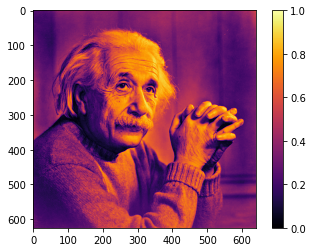

In [101]:
import os
import numpy as np
import scipy.stats as scs
import pickle
import joblib
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from Ratio import *
from Ratio_L_and_W import *

start = time.time()

import matplotlib.image as mpimg

img=mpimg.imread('../einstein.png')#'emily1.jpg')#

# rescale to 0,1
img = (img - np.min(img)) / (np.max(img) - np.min(img))
#img = np.abs(img - 1.0) 
#img = img[:400,:450]
plt.imshow(img, cmap='inferno')
plt.colorbar()

np.random.seed(990109)
torch.manual_seed(990109)

N_TRAIN = 5000
N_TEST = 5000

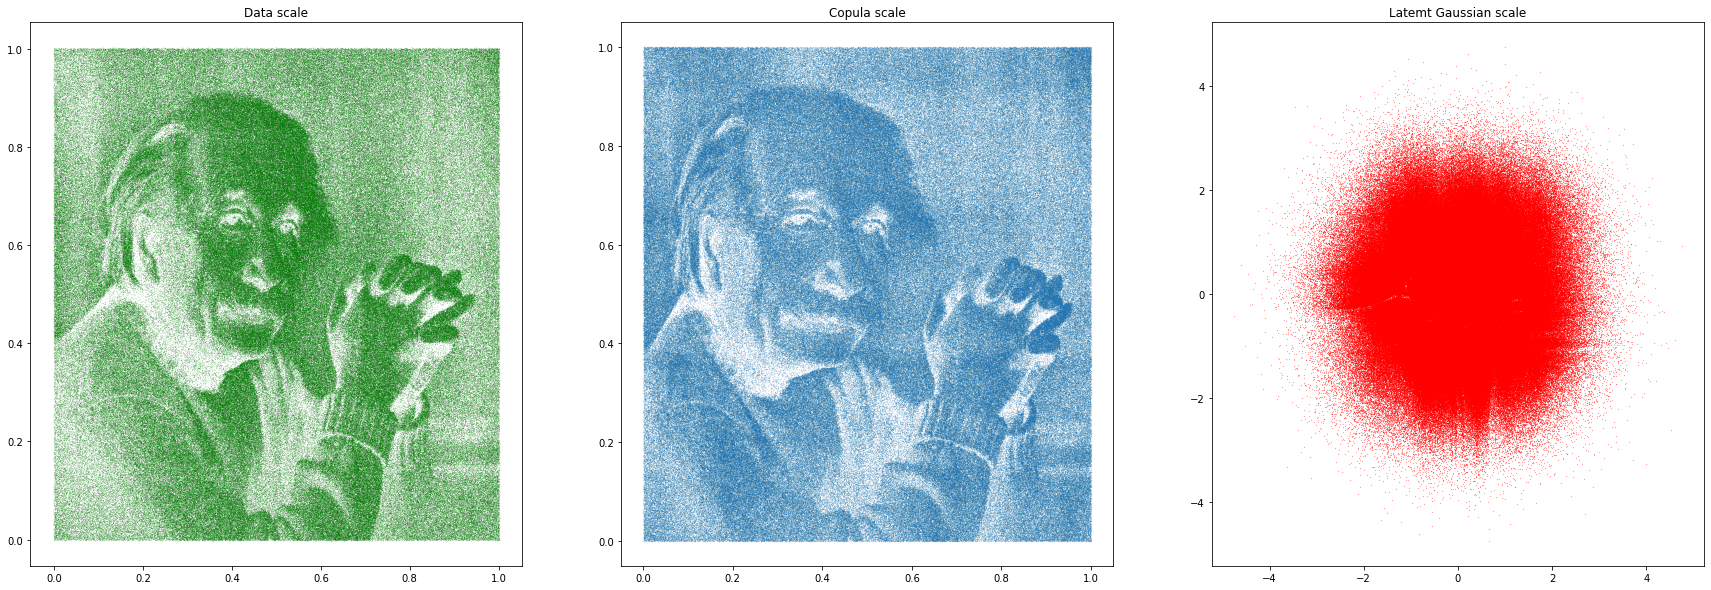

In [118]:
img_probs = img/ np.sum(img)
sample_idx = np.random.choice(np.arange(img_probs.flatten().shape[0]), size=1000000,  p=img_probs.flatten())
x = np.linspace(0, 1, img.shape[1])
y = np.linspace(1, 0, img.shape[0])
X, Y = np.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()
X = X[sample_idx]
Y = Y[sample_idx]
data_p = np.stack([X, Y], axis=1) + np.random.normal(0, 0.001, (X.shape[0], 2))

from statsmodels.distributions.empirical_distribution import ECDF

cdf_1 = ECDF(data_p[:,0])
cdf_2 = ECDF(data_p[:,1])

from scipy.interpolate import interp1d
import scipy 

slope_changes = sorted(set(data_p[:,0]))

sample_edf_values_at_slope_changes1 = [ cdf_1(item) for item in slope_changes]
sample_edf_values_at_slope_changes2 = [ cdf_2(item) for item in slope_changes]

# Extend the range of the input values by 0.1
extended_sample_edf_values1 = np.concatenate(([sample_edf_values_at_slope_changes1[0] - 0.01], sample_edf_values_at_slope_changes1, [sample_edf_values_at_slope_changes1[-1] + 0.1]))
extended_sample_edf_values2 = np.concatenate(([sample_edf_values_at_slope_changes2[0] - 0.01], sample_edf_values_at_slope_changes2, [sample_edf_values_at_slope_changes2[-1] + 0.1]))
extended_slope_changes = np.concatenate(([slope_changes[0] - 0.1], slope_changes, [slope_changes[-1] + 0.1]))

# Create the interpolating functions with extrapolation
inverted_cdf1 = interp1d(extended_sample_edf_values1, extended_slope_changes, bounds_error=False, fill_value="extrapolate")
inverted_cdf2 = interp1d(extended_sample_edf_values2, extended_slope_changes, bounds_error=False, fill_value="extrapolate")

u = cdf_1(data_p[:,0])
v = cdf_2(data_p[:,1])

z1 = scipy.stats.norm.ppf(u)
z2 = scipy.stats.norm.ppf(v)
z = np.stack([z1, z2], axis=1)
z = np.nan_to_num(z, nan=0, posinf=0, neginf=0)

# do a 3 subplot
fig, ax = plt.subplots(1,3, figsize=(30,10))
ax[0].scatter(data_p[:,0],data_p[:,1],s=0.002,c='green')
ax[1].scatter(u,v, s=0.003)
ax[2].scatter(z1,z2, s=0.002, c='red')
# titles for each
ax[0].set_title('Data scale')
ax[1].set_title('Copula scale')
ax[2].set_title('Latemt Gaussian scale')

plt.show()

# Simple NNEt

In [103]:
# train ratio copula
from Ratio import Ratio
from Ratio import loss_nce
from tqdm import tqdm
from torch import tensor as tt
u1, u2 = u,v

q_data = np.random.randn(5000,2)
ratio = Ratio(h_dim=100, in_dim=2, h_layers=5)

optimizer = torch.optim.Adam(ratio.parameters(), lr= 0.002)
z[z==np.inf] = 0


for epoch in tqdm(range(2)):
    optimizer.zero_grad()
    r_p = ratio(tt(z[np.random.choice(range(z.shape[0]),size=5000)]).float())
    r_q = ratio(tt(np.random.randn(5000,2)).float())
    #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
    loss = loss_nce(r_p, r_q, 5000, 5000)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            print(f'Epoch {epoch}, loss {loss.item()}')

model = ratio

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

Epoch 0, loss 1.5466457605361938


In [121]:

model.load_state_dict(
torch.load('NNet_ratio_einstein_simpleNNet_1Ms_100Ke_5L_no_noise_10Kbatches_actual100Ke.pt'))


<All keys matched successfully>

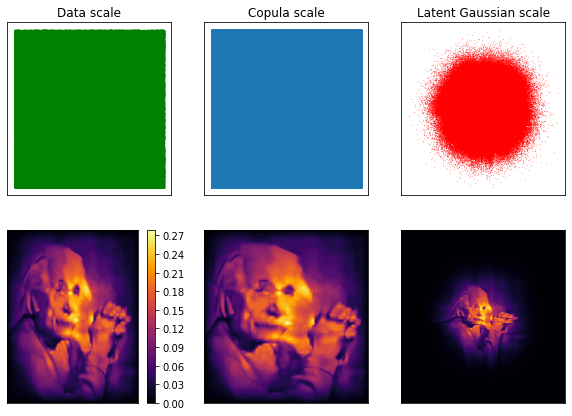

In [122]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

meshgrid = np.meshgrid(np.linspace(-4,4,200), np.linspace(-4,4,200))

ratio_grid = model(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy() # 1000x1000
gauss = torch.distributions.MultivariateNormal(tt([0.,0.]), tt([[1.,0.],[0.,1.]])).log_prob(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1,1).detach().numpy()
    
ratio_grid = np.clip(ratio_grid, a_min=-np.inf, a_max=10.)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 7))  # Adjusted for 6 plots

# Original scatter plots

ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
#ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')
# Remove ticks from contour plots
for i in range(3):
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
# Original contour plots with colorbars
in_1 = scs.norm.cdf(meshgrid[0])#np.clip(,a_max=0.99999,a_min=0.00001)
in_2 = scs.norm.cdf(meshgrid[1])#np.clip(,a_max=0.99999,a_min=0.00001)

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1),inverted_cdf2(in_2), (gauss* ratio_grid).reshape(200, 200),levels=100,cmap='inferno')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss*ratio_grid).reshape(200, 200),levels=100,cmap='inferno')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss*ratio_grid).reshape(200, 200),levels=100,cmap='inferno')
plt.colorbar(contour_set, ax=ax[1, 0])
# Remove ticks from contour plots
for i in range(3):
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])


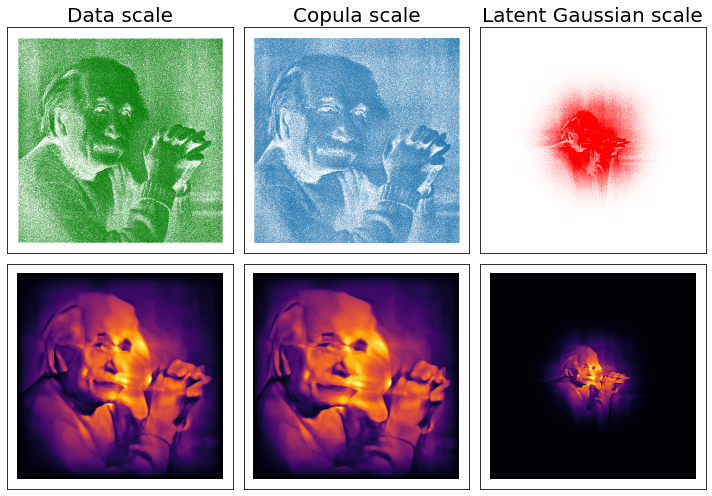

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
import matplotlib.cm as cm

xy_ = np.max(np.abs(z))
meshgrid = np.meshgrid(np.linspace(-xy_, xy_, 1000), np.linspace(-xy_, xy_, 1000))

ratio_grid = model(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy()  # 1000x1000
ratio_grid = (np.clip(ratio_grid, a_min=0.01, a_max=4.))
ratio_grid[ratio_grid==np.nan] = 0
gauss = torch.distributions.MultivariateNormal(tt([0., 0.]), tt([[1., 0.], [0., 1.]])).log_prob(
    tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1, 1).detach().numpy()

ratio_grid = np.clip(ratio_grid, a_min=-np.inf, a_max=4.)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 7))  # Adjusted for 6 plots

# Original scatter plots

ax[0, 0].scatter(data_p[:, 0], data_p[:, 1], s=0.005, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=0.005, alpha=0.2)
# ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.00001, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale', fontsize=20)
ax[0, 1].set_title('Copula scale', fontsize=20)
ax[0, 2].set_title('Latent Gaussian scale', fontsize=20)
# Remove ticks from scatter plots
for i in range(3):
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

# Original contour plots with colorbars
in_1 = scs.norm.cdf(meshgrid[0])  # np.clip(,a_max=0.99999,a_min=0.00001)
in_2 = scs.norm.cdf(meshgrid[1])  # np.clip(,a_max=0.99999,a_min=0.00001)

contourf_lvl = 100

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), (gauss * ratio_grid).reshape(1000, 1000),
                                levels=contourf_lvl, cmap='inferno')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss * ratio_grid).reshape(1000, 1000),
                                levels=contourf_lvl, cmap='inferno')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss * ratio_grid).reshape(1000, 1000), levels=contourf_lvl, cmap='inferno')
#plt.colorbar(contour_set, ax=ax[1, 0])

# Remove ticks from contour plots and set the same x and y limits as the top row
for i in range(3):
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xlim(ax[0, i].get_xlim())
    ax[1, i].set_ylim(ax[0, i].get_ylim())

# Set the background color of the bottom row plots to the lowest color of the inferno_r colormap
#lowest_color = cm.inferno(0)
#for i in range(3):
#    ax[1, i].set_facecolor(lowest_color)

plt.tight_layout()

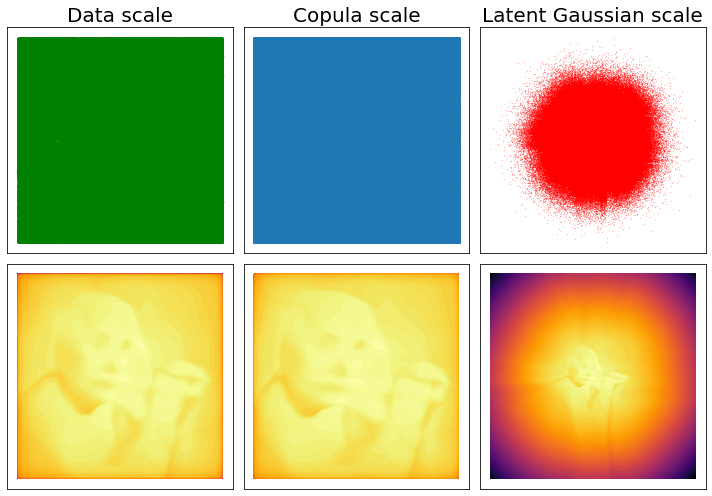

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
import matplotlib.cm as cm

xy_ = np.max(np.abs(z))
meshgrid = np.meshgrid(np.linspace(-xy_, xy_, 1000), np.linspace(-xy_, xy_, 1000))

ratio_grid = model(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy()  # 1000x1000
gauss = torch.distributions.MultivariateNormal(tt([0., 0.]), tt([[1., 0.], [0., 1.]])).log_prob(
    tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1, 1).detach().numpy()

#ratio_grid = np.clip(ratio_grid, a_min=0.1, a_max=4.)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 7))  # Adjusted for 6 plots

# Original scatter plots

ax[0, 0].scatter(data_p[:, 0], data_p[:, 1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
# ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale', fontsize=20)
ax[0, 1].set_title('Copula scale', fontsize=20)
ax[0, 2].set_title('Latent Gaussian scale', fontsize=20)
# Remove ticks from scatter plots
for i in range(3):
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])

# Original contour plots with colorbars
in_1 = scs.norm.cdf(meshgrid[0])  # np.clip(,a_max=0.99999,a_min=0.00001)
in_2 = scs.norm.cdf(meshgrid[1])  # np.clip(,a_max=0.99999,a_min=0.00001)

contourf_lvl = 100

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), np.log(gauss * ratio_grid).reshape(1000, 1000),
                                levels=contourf_lvl, cmap='inferno')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), np.log(gauss * ratio_grid).reshape(1000, 1000),
                                levels=contourf_lvl, cmap='inferno')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], np.log(gauss * ratio_grid).reshape(1000, 1000), levels=contourf_lvl, cmap='inferno')
#plt.colorbar(contour_set, ax=ax[1, 0])

# Remove ticks from contour plots and set the same x and y limits as the top row
for i in range(3):
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xlim(ax[0, i].get_xlim())
    ax[1, i].set_ylim(ax[0, i].get_ylim())

# Set the background color of the bottom row plots to the lowest color of the inferno_r colormap
#lowest_color = cm.inferno_r(0)
#for i in range(3):
#    ax[1, i].set_facecolor(lowest_color)

plt.tight_layout()

# TRE

In [76]:
# Fit W_ratio on all examples

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# u1_u2 = [u1, u2]
p_data = z
p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
# Fit Ratio copula
ratio = W_Ratio_fit(z_cop=p_data[:2],waymarks=5,return_waymark_datasets=False)

# Save the model parameters
#model_path = f'model_parameters_W_ratio_25_runs_4copulas_2Dexperiment/NNet_ratio_run_{r}_cop_u_{u}.pt'
#torch.save([r.state_dict() for r in ratio], model_path)


Epoch 500, normalising constant 1.0361701250076294 0.5366652011871338
Epoch 500, normalising constant 1.0134624242782593 2.9730429649353027
Epoch 500, normalising constant 1.0069196224212646 2.8502609729766846
Epoch 500, normalising constant 1.0126129388809204 2.737408399581909


In [77]:
# Load the state dictionaries into the model instances
state_dicts = torch.load('W_ratio_cop_im_100Ks_5W_50e_100Knoise.pt')

for i,(r, state_dict) in enumerate(zip(ratio, state_dicts)):
    #print(i)
    r.load_state_dict(state_dict)

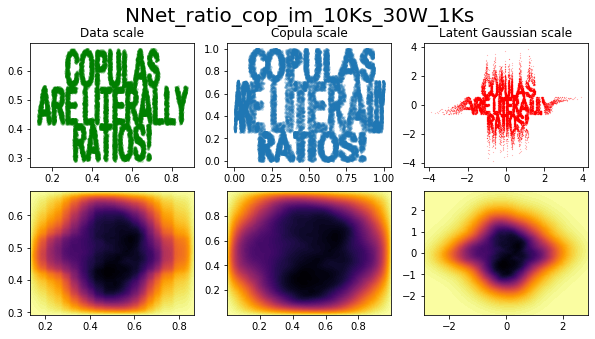

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs
from torch import tensor as tt

meshgrid = np.meshgrid(np.linspace(-2.9,2.9,200), np.linspace(-2.9,2.9,200))

ratio_grid = W_ratio_compute(ratio,(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).detach().numpy() )# 1000x1000
ratio_grid = ratio_grid.detach().numpy()
gauss = torch.distributions.MultivariateNormal(tt([0.,0.]), tt([[1.,0.],[0.,1.]])).log_prob(tt(np.stack([meshgrid[0].flatten(), meshgrid[1].flatten()], axis=1)).float()).exp().reshape(-1,1).detach().numpy()
    
#ratio_grid = np.clip(ratio_grid, a_min=0.01, a_max=1.5)
# Adjust the subplot configuration to 2 rows by 3 columns
fig, ax = plt.subplots(2, 3, figsize=(10, 5))  # Adjusted for 6 plots
fig.suptitle('NNet_ratio_cop_im_10Ks_30W_1Ks', fontsize=20)
# Original scatter plots

ax[0, 0].scatter(data_p[:,0], data_p[:,1], s=3, c='green', alpha=0.2)
ax[0, 1].scatter(u, v, s=3, alpha=0.2)
#ax[0, 2].scatter(scs.norm.rvs(size=10000), scs.norm.rvs(size=10000), s=1, c='black')
ax[0, 2].scatter(z1, z2, s=0.01, c='red')

# Titles for each scatter plot
ax[0, 0].set_title('Data scale')
ax[0, 1].set_title('Copula scale')
ax[0, 2].set_title('Latent Gaussian scale')

# Original contour plots with colorbars
in_1 = scs.norm.cdf(meshgrid[0])# np.clip(,a_max=0.999,a_min=0.0004)
in_2 =scs.norm.cdf(meshgrid[1])#  np.clip(,a_max=0.999,a_min=0.0004)

contour_set = ax[1, 0].contourf(inverted_cdf1(in_1),inverted_cdf2(in_2), (gauss* ratio_grid).reshape(200, 200),levels=100,cmap='inferno_r')
contour_set = ax[1, 1].contourf(scs.norm.cdf(meshgrid[0]), scs.norm.cdf(meshgrid[1]), (gauss*ratio_grid).reshape(200, 200),levels=100,cmap='inferno_r')
contour_set = ax[1, 2].contourf(meshgrid[0], meshgrid[1], (gauss*ratio_grid).reshape(200, 200),levels=100,cmap='inferno_r')


In [102]:
z[z==np.inf] = 0
kde = scs.gaussian_kde(z.T, bw_method=0.02)
x, y = np.linspace(-3.9, 3.9, 100), np.linspace(-2.9, 2.9, 100)
X, Y = np.meshgrid(x, y)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)


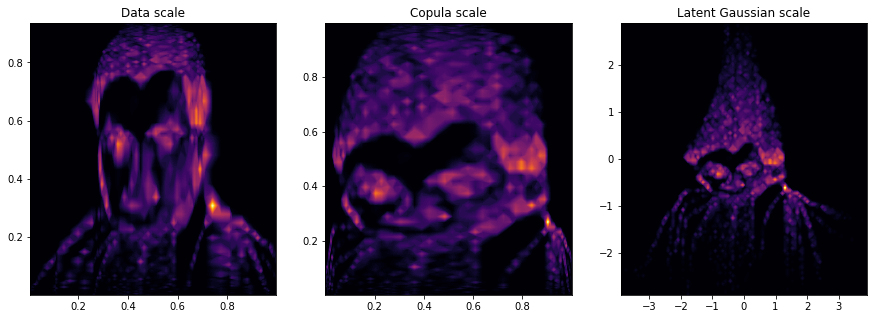

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scs

# Assuming X, Y, Z are already defined
# X, Y = np.meshgrid(np.linspace(-2.9, 2.9, 100), np.linspace(-2.9, 2.9, 100))
# Z = some_function_to_compute_Z(X, Y)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots in a row

# First subplot - data scale
in_1 = np.clip(scs.norm.cdf(X), a_max=0.999, a_min=0.001)
in_2 = np.clip(scs.norm.cdf(Y), a_max=0.999, a_min=0.001)
ax[0].contourf(inverted_cdf1(in_1), inverted_cdf2(in_2), Z, levels=100, cmap='inferno')
ax[0].set_title('Data scale')

# Second subplot - Copula scale
ax[1].contourf(scs.norm.cdf(X), scs.norm.cdf(Y), Z, levels=100, cmap='inferno')
ax[1].set_title('Copula scale')

# Third subplot - Latent Gaussian scale
ax[2].contourf(X, Y, Z, levels=100, cmap='inferno')
ax[2].set_title('Latent Gaussian scale')

plt.show()